In [1]:
from api_wrappers.kraken_wrapper import KrakenWrapper

wrapper = KrakenWrapper(lb_interval="4hr")
dfs = wrapper.load_hist_files()

c:\Users\nick5\miniconda3\envs\tree-env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
print(len(dfs))

22


In [3]:
import numpy as np
import random
from networks.attention_agent import CausalAttentionAgent
import torch
from utils.trading_gym_env import TradingEnv
from utils.synthetic_data_service import SyntheticOHLCVGenerator
import pandas as pd
import matplotlib.pyplot as plt
from diffevo import DDIMScheduler, BayesianGenerator
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from utils.fitess_funcs import batched_fitness_function
from api_wrappers.kraken_wrapper import KrakenWrapper
from utils.feature_functions import apply_slope_features, ensemble_features

print(len(dfs))
non_featurecols = list(dfs.items())[0][1].columns
def add_features(df):
    df.columns = [col.lower() for col in df.columns]
    print(df.head())
    # Ensure columns are numeric
    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df['high'] = pd.to_numeric(df['high'], errors='coerce')
    df['low'] = pd.to_numeric(df['low'], errors='coerce')
    df['vol'] = pd.to_numeric(df['vol'], errors='coerce')

    # Add log returns
    df['log_return'] = np.log(df['close']).diff()

    # Add moving averages
    df['ma_10'] = df['close'].pct_change(5).rolling(window=10).mean()
    '''df['ma_21'] = df['close'].rolling(window=21).mean()
    df['ma_34'] = df['close'].rolling(window=34).mean()'''
    df['ma_50'] = df['close'].pct_change(5).rolling(window=50).mean()
    df = ensemble_features(df)
    df = apply_slope_features(df, ['close', 'vol'], dropna=False)
    # Add Fibonacci levels
    fib_ratios = [0.0, 0.236, 0.382, 0.5, 0.618, 1.0]
    for ratio in fib_ratios:
        df[f'fib_{int(ratio * 1000)}'] = np.nan
    for i in range(50, len(df)):
        high = df['high'].iloc[i-50:i].max()
        low = df['low'].iloc[i-50:i].min()
        for ratio in fib_ratios:
            level = high - (high - low) * ratio
            dist_to_level = (df['close'].iloc[i] - level) / level
            df.at[i, f'fib_{int(ratio * 1000)}'] = dist_to_level

    # Drop NaN rows
    df = df.dropna().reset_index(drop=True)
    return df

# Add features to all dataframes
dfs = {asset: add_features(df) for asset, df in dfs.items()}

train_size = int(len(list(dfs.items())[0][1]) * 0.6)
def split_train_test(df, train_ratio=0.8):
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]
    return train_df, test_df

# Split all dataframes into train/test sets
train_test_data = {asset: split_train_test(df) for asset, df in dfs.items()}
def prepare_data(df, seq_len):
    states = []
    price_changes = []
    feature_cols = [c for c in df.columns if c not in non_featurecols]
    print(feature_cols)
    for i in range(len(df) - seq_len):
        state = df.iloc[i:i+seq_len][feature_cols].values
        price_change = df.iloc[i+seq_len]['log_return']
        states.append(state)
        price_changes.append(price_change)

    states = torch.tensor(states, dtype=torch.float32)  # Shape: (num_samples, seq_len, num_features)
    price_changes = torch.tensor(price_changes, dtype=torch.float32)  # Shape: (num_samples,)
    return states, price_changes

# Prepare data for all assets
seq_len = 144
train_data = {asset: prepare_data(train, seq_len) for asset, (train, _) in train_test_data.items()}
test_data = {asset: prepare_data(test, seq_len) for asset, (_, test) in train_test_data.items()}

22
         date      open      high       low     close      vwap           vol
0  1694390400  0.249169  0.249169  0.236997  0.242000  0.241745  1.630805e+06
1  1694476800  0.242000  0.252356  0.240993  0.245998  0.248591  1.011622e+06
2  1694563200  0.245534  0.249705  0.243873  0.248728  0.247799  2.463036e+05
3  1694649600  0.248832  0.252286  0.246532  0.251329  0.249129  1.596386e+05
4  1694736000  0.251267  0.254644  0.237800  0.250528  0.244553  3.753199e+06
         date     open     high      low    close     vwap            vol
0  1694390400  0.09131  0.09202  0.08760  0.08844  0.08886   44115.023285
1  1694476800  0.08896  0.09198  0.08859  0.08965  0.09029  191172.611332
2  1694563200  0.08921  0.09195  0.08900  0.09089  0.09070   78639.702407
3  1694649600  0.09122  0.09379  0.09050  0.09347  0.09216  121614.765609
4  1694736000  0.09352  0.09671  0.09328  0.09630  0.09462   86333.150052
         date    open    high     low   close    vwap          vol
0  1694390400  1.2

C:\Users\nick5\AppData\Local\Temp\ipykernel_16900\4152013123.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32)  # Shape: (num_samples, seq_len, num_features)


['log_return', 'ma_10', 'ma_50', 'ma_short', 'ma_long', 'rsi', 'Signal', 'close_angle_2', 'vol_angle_2', 'close_angle_3', 'vol_angle_3', 'close_angle_5', 'vol_angle_5', 'close_angle_8', 'vol_angle_8', 'close_angle_13', 'vol_angle_13', 'close_angle_21', 'vol_angle_21', 'close_angle_34', 'vol_angle_34', 'close_angle_55', 'vol_angle_55', 'close_angle_89', 'vol_angle_89', 'fib_0', 'fib_236', 'fib_382', 'fib_500', 'fib_618', 'fib_1000']
['log_return', 'ma_10', 'ma_50', 'ma_short', 'ma_long', 'rsi', 'Signal', 'close_angle_2', 'vol_angle_2', 'close_angle_3', 'vol_angle_3', 'close_angle_5', 'vol_angle_5', 'close_angle_8', 'vol_angle_8', 'close_angle_13', 'vol_angle_13', 'close_angle_21', 'vol_angle_21', 'close_angle_34', 'vol_angle_34', 'close_angle_55', 'vol_angle_55', 'close_angle_89', 'vol_angle_89', 'fib_0', 'fib_236', 'fib_382', 'fib_500', 'fib_618', 'fib_1000']
['log_return', 'ma_10', 'ma_50', 'ma_short', 'ma_long', 'rsi', 'Signal', 'close_angle_2', 'vol_angle_2', 'close_angle_3', 'vol_a

In [4]:
import torch.nn.functional as F

def run(x_array, population, agent):
    rewards = []
    # Example of a random walk in the environment
    for xp in population:
        vector_to_parameters(torch.tensor(xp, dtype=torch.float32), agent.parameters())
        rewards.append(batched_fitness_function(agent, x_array))
    return rewards

# Define hyperparameters
POP_SIZE = 233
SCALING = 0.5

# Instantiate the model
STATE_DIM = train_data[list(train_data.keys())[0]][0].shape[-1]  # Number of features
ACTION_DIM = 2  # Buy, Sell
EP_LEN = 34
agent_model = CausalAttentionAgent(state_dim=STATE_DIM, num_heads=8, embed_dim=64, action_dim=ACTION_DIM, seq_len=seq_len)

# Initialize population
dim = parameters_to_vector(agent_model.parameters()).shape[0]
population = torch.randn(POP_SIZE, dim) * SCALING

def fitness_function(population, agent, train_data, num_assets=10, device="cuda"):
    """
    Evaluate the fitness of the population on a randomly selected batch of assets.

    Args:
        population: The population of agent parameters.
        agent: The trading agent model.
        train_data: Dictionary of training data for all assets.
        num_assets: Number of assets to randomly select for evaluation.
        device: The device to run the computation on ("cuda" or "cpu").

    Returns:
        Tensor of normalized rewards for each member of the population.
    """
    # Move agent to the device
    agent.to(device)

    # Randomly select a batch of assets
    selected_assets = random.sample(list(train_data.keys()), num_assets)
    print(f"Selected assets for this generation: {selected_assets}")

    # Combine states and price changes for the selected assets
    batch_states = torch.stack([train_data[asset][0] for asset in selected_assets], dim=0).to(device)  # Shape: (batch, ep_len, seq_len, features)
    batch_price_changes = torch.stack([train_data[asset][1] for asset in selected_assets], dim=0).to(device)  # Shape: (batch, ep_len)

    # Initialize rewards for the population
    population_rewards = torch.zeros(len(population), len(selected_assets), device=device)  # Shape: (population_size, num_assets)

    for i, params in enumerate(population):
        # Update the agent's parameters
        vector_to_parameters(params.to(device), agent.parameters())

        # Evaluate the agent on the batch
        rewards = batched_fitness_function(agent, batch_states, batch_price_changes)  # Shape: (batch, 1)
        population_rewards[i] = rewards.squeeze()  # Store rewards for this parameter set

    # Normalize rewards per parameter set using softmax across assets
    normalized_rewards = F.softmax(population_rewards, dim=0)  # Normalize across assets for each parameter set

    # Sum normalized rewards across all assets for each parameter set
    final_rewards = normalized_rewards.sum(dim=1)  # Shape: (population_size,)

    return final_rewards

# Train with diffusion evolution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

scheduler = DDIMScheduler(num_step=610)
population = population.to(device)  # Move population to GPU

'''for t, alpha in scheduler:  # Number of training steps
    rewards = fitness_function(population, agent_model, train_data, device=device)
    print(f"Step {t}, Best Reward: {max(rewards)}")
    population = population.cpu()  # Move population to CPU for generator
    generator = BayesianGenerator(population, rewards.cpu(), alpha)
    population = generator(noise=0).to(device)  # put new population on gpu

    best_para = population[-1]
    torch.save(best_para, 'best_attention_agent_4hr.pth')'''

Using device: cuda


'for t, alpha in scheduler:  # Number of training steps\n    rewards = fitness_function(population, agent_model, train_data, device=device)\n    print(f"Step {t}, Best Reward: {max(rewards)}")\n    population = population.cpu()  # Move population to CPU for generator\n    generator = BayesianGenerator(population, rewards.cpu(), alpha)\n    population = generator(noise=0).to(device)  # put new population on gpu\n\n    best_para = population[-1]\n    torch.save(best_para, \'best_attention_agent_4hr.pth\')'

torch.Size([51906])
torch.Size([51906])
Selected assets for evaluation: ['MANAUSDT.txt', 'ALGOUSDT.txt', 'LINKUSDT.txt', 'XTZUSDT.txt', 'XDGUSDT.txt', 'ADAUSDT.txt', 'APEUSDT.txt', 'AVAXUSDT.txt', 'SHIBUSDT.txt', 'ETHUSDT.txt']
torch.Size([10, 109])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0])
tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0])
tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 0])
tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 0])
tensor([1, 1, 0, 1, 1, 1, 0, 0, 1, 0])
tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 0])
tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 0])
tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 0])
tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 0, 1, 1, 0, 0, 0, 1, 0])
tensor([1, 1, 0, 1, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 0])
tensor([1, 0, 0, 1, 1, 1, 1, 0, 1, 0])
tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 0, 1, 1, 1, 0, 0, 0, 0])
tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 0])
tensor([1

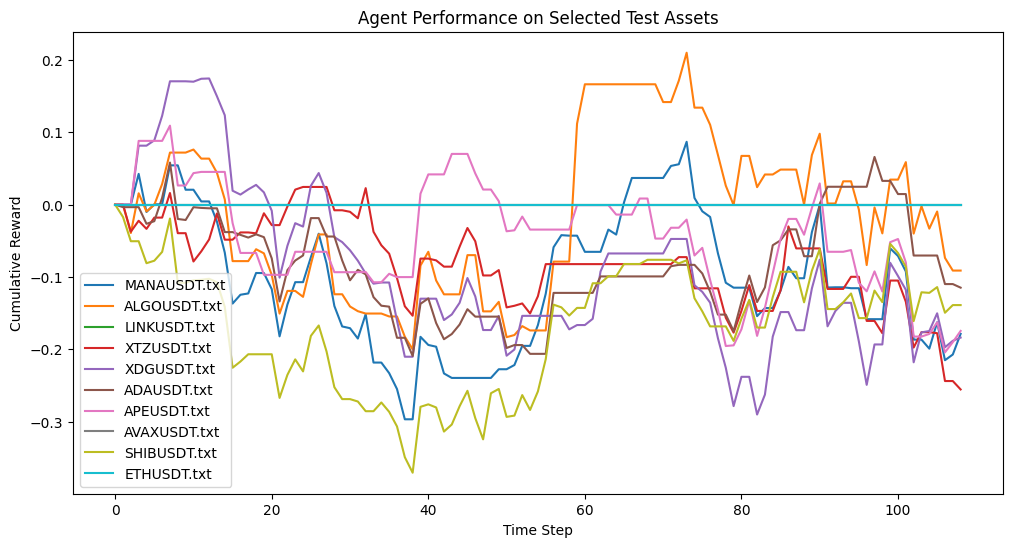

Test rewards for the best agent: tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.2150, -0.2071, -0.1786],
        [ 0.0000,  0.0000, -0.0392,  ..., -0.0736, -0.0911, -0.0911],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0170, -0.0505,  ..., -0.1494, -0.1388, -0.1388],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [8]:
import matplotlib.pyplot as plt
# Load the saved population
saved_population_path = 'best_attention_agent.pth'
best_params = torch.load(saved_population_path, weights_only=False)
current_params = parameters_to_vector(agent_model.cpu().parameters())
print(current_params.shape)
print(best_params.shape)
vector_to_parameters(best_params, agent_model.parameters())
# Evaluate the best parameters on the test set and plot performance
def evaluate_population_on_test(agent, test_data, num_assets=10):
    """
    Evaluate the saved population on the test set and plot performance.

    Args:
        agent: The trading agent model.
        test_data: Dictionary of test data for all assets.
        num_assets: Number of assets to randomly select for evaluation.

    Returns:
        List of rewards for the best parameters on the test set.
    """
    # Randomly select a batch of assets
    selected_assets = random.sample(list(test_data.keys()), num_assets)
    print(f"Selected assets for evaluation: {selected_assets}")

    # Combine states and price changes for the selected assets
    batch_states = torch.stack([test_data[asset][0] for asset in selected_assets], dim=0)  # Shape: (batch, ep_len, seq_len, features)
    batch_price_changes = torch.stack([test_data[asset][1] for asset in selected_assets], dim=0)  # Shape: (batch, ep_len)

    # Load the best parameters into the agent
    vector_to_parameters(best_params.cpu(), agent.parameters())

    # Evaluate the agent on the test set
    batch, ep_len = batch_price_changes.shape
    print(batch_price_changes.shape)
    rewards = torch.zeros(batch, ep_len)  # Initialize rewards for each asset over time

    for t in range(ep_len - 1):
        # Get the current state for all assets at time t
        current_states = batch_states[:, t, :, :]  # Shape: (batch, seq_len, features)

        # Get actions for all assets in the batch
        actions = agent(current_states)  # Shape: (batch, 2) -> 2 actions: Buy, Sell
        actions = torch.argmax(actions, dim=-1)  # Convert to discrete actions (0=Sell, 1=Buy)

        # Convert actions to -1 (Sell) and 1 (Buy)
        #actions = actions.float() * 2 - 1  # Map (0, 1) -> (-1, 1)
        print(actions)
        # Calculate rewards as the product of actions and percentage changes
        rewards[:, t + 1] = rewards[:, t] + (actions * batch_price_changes[:, t + 1])

    # Plot cumulative rewards for each asset
    plt.figure(figsize=(12, 6))
    for i, asset in enumerate(selected_assets):
        plt.plot(rewards[i].numpy(), label=asset)
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Reward')
    plt.title('Agent Performance on Selected Test Assets')
    plt.legend()
    plt.show()

    return rewards

# Evaluate the best agent on the test set and plot performance
test_rewards = evaluate_population_on_test(agent_model, test_data, num_assets=10)
print("Test rewards for the best agent:", test_rewards)